# Sources and receivers in SeisCL

This example show how to set up the source(s) of the seismic wave and the geophones to receive it.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seis = SeisCL()

We will again start by setting up the relevant constants of a simple 2D model. 

In [22]:
seis.csts['ND'] = 2
seis.csts['N'] = np.array([200, 500])
seis.csts['dt'] = dt = 0.25e-03
seis.csts['dh'] = dh = 2
seis.csts['NT'] = NT = 1500
seis.csts['FDORDER'] = 4

In SeisCL, the sources and the receivers informations are written into two list `src_pos_all` and `rec_pos_all` which are of length \[ 5 x number of sources \] and \[ 8 x number of receivers \].  They must be given in the following format:

<br>

| Src\_pos\_all input | Description |
| :-: | :-: |
| sx | Position of the receiver in X |
| sy | Position of the receiver in Y |
| sz | Position of the receiver in Z |
| srcid | Source ID : Each receiver is associated with one source ID <br> Same ID are fired simultaneously |
| src_type | Type of the source : $\hspace{0.1cm}$ 0 : Force in X<br> $\hspace{3cm}$ 1 : Force in Y<br> $\hspace{3cm}$ 2 : Force in Z <br> $\hspace{2.6cm}$ 100 : Explosive |

<br>
<br>

| Rec\_pos\_all input | Description |
| :-: | :-: |
| gx | Position of the source in X |
| gy | Position of the source in Y |
| gz | Position of the source in Z |
| srcid | Id of the source related to this receiver |
| recid | Trace number |
| -- | Blank |
| -- | Blank |
| -- | Blank |

<br>

For now, the receivers have eight inputs, but only five of them are useful so the last three are left blank.


An explosive source correspond to a force which excites P-waves only and that is radiating with the same amplitude into all directions.

Finally, note that by default the source is define as a ricker wavelet which is given by : $\normalsize \psi(t) = {2 \over {\sqrt {3\sigma}\pi^{1 \over 4}}} \left( 1 - {t^2 \over \sigma^2} \right) e^{-t^2 \over 2\sigma^2}$



With this in mind, we can start by simply create an explosive shot in the middle of our domain and a list of receiver near the surface of the model.

In [23]:
Nz = seis.csts['N'][0]
Nx = seis.csts['N'][1]

sx = Nx // 2 * dh
sy = 0
sz = Nz // 2 * dh
srcid = 0
src_type = 100

seis.src_pos_all = np.stack([[sx], [sy], [sz], [srcid], [src_type]], axis=0)

gx = np.arange(50*dh, 450*dh, 5*dh)
gy = gx * 0
gz = gx * 0 + 20 * dh
gsid = gx*0
recid = np.arange(0, len(gx))
Blank = gx*0

seis.rec_pos_all = np.stack([gx, gy, gz, gsid, recid, Blank, Blank, Blank], axis=0)

Here, all the receivers are associated with the single source, so `gsid` which link the receivers and the source take a value of `srcid = 0` for all of the receivers. 

Finally, let's take the same three-layer model that we created in the [Model Building](Model_Building.ipynb) notebook.

In [24]:
vp = [3500, 2000, 2500]
vs = 2000
rho = 2000
taup = 0
taus = 0

Ep_vp = [Nz//5, Nz//3]

vp_1 = np.zeros((Ep_vp[0], Nx)) + vp[0]
vp_2 = np.zeros((Ep_vp[1], Nx)) + vp[1]
vp_3 = np.zeros((Nz-np.sum(Ep_vp), Nx)) + vp[2]

vp_all = np.vstack((vp_1, vp_2, vp_3))

vs_all = np.zeros(seis.csts['N']) + vs
rho_all = np.zeros(seis.csts['N']) + rho
taup_all = np.zeros(seis.csts['N']) + taup
taus_all = np.zeros(seis.csts['N']) + taus


Model3Layers = {"vp": vp_all, "rho": rho_all, "vs": vs_all, "taup": taup_all, "taus": taus_all}

Let's visualize our domain

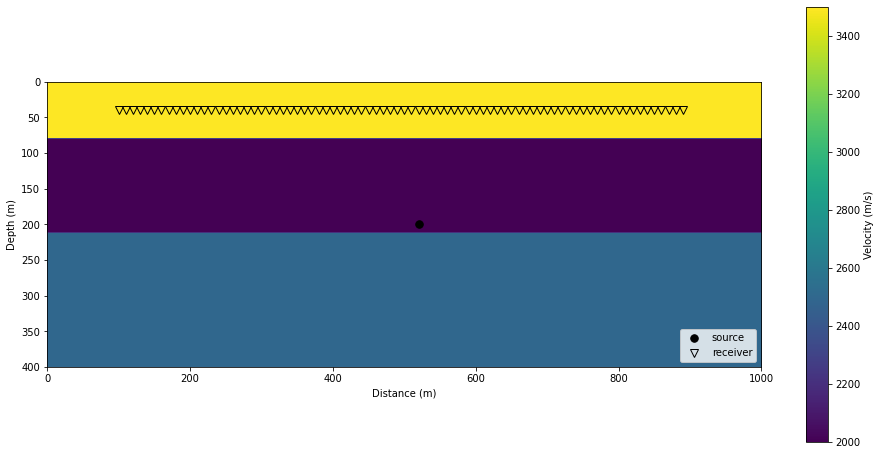

In [25]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seis.DrawDomain2D(vp_all, ax = ax, ShowSrcRec = True)

We now have everything we need, so we can run the simulation and show the result.

In [26]:
seis.csts['seisout'] = 1
seis.set_forward(srcid, Model3Layers, withgrad=False)
seis.execute()
data_geophone = seis.read_data()
data_geophone = data_geophone[-1]

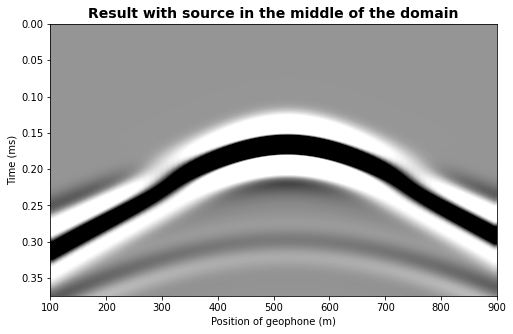

In [27]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5])
extent = [50*dh, 450*dh, (data_geophone.shape[0]-1)*dt, 0]
clip = 0.1
vmax = np.max(data_geophone) * clip
vmin = -vmax
ax.imshow(data_geophone, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax.set_title("Result with source in the middle of the domain", fontsize=14, fontweight='bold')
ax.set_xlabel("Positions (m)")
ax.set_ylabel("Time (ms)")
plt.show()

## Multiple shot

<br>

Here, we show how to use sources IDs to efficiently carrying out simulation on random shots over multiple positions. 

First we create a list with all possible positions of shots and receivers.
 
Each variable of `rec_pos_all` should have a length of \[ nb of receivers $\times$ nb of sources \] if each geophone can receive from each source.


In [28]:
seis.src_pos_all = np.empty((5, 0))
seis.rec_pos_all = np.empty((8, 0))
seis.src_all = None


sx_allshot = np.arange(50, 950 + dh, dh)
sy_allshot = sx_allshot * 0
sz_allshot = sx_allshot* 0 + Nz // 2 * dh
srcid_allshot = np.arange(0, len(sx_allshot))
src_type_allshot = sx_allshot * 0 + 100

seis.src_pos_all = np.stack([sx_allshot, sy_allshot, sy_allshot,
                        srcid_allshot, src_type_allshot], axis=0)


gx_allshots = np.tile(gx, len(sx_allshot))
gy_allshots = np.tile(gy, len(sy_allshot))
gz_allshots = np.tile(gz, len(sz_allshot))
gsid_allshots = np.repeat(srcid_allshot, len(gx))
recid_allshots = np.arange(0, len(gx_allshots), 1)
Blank_allshots = np.tile(Blank, len(sx_allshot))

seis.rec_pos_all = np.stack([gx_allshots, gy_allshots, gz_allshots,
                            gsid_allshots, recid_allshots, Blank_allshots,
                            Blank_allshots, Blank_allshots], axis=0)



We can now iterate over the srcids and pass the chosen ones to `set_foward` which will only write the desired sources on the disk. 

In [29]:
datashots = []
jobids = np.random.choice(srcid_allshot, 4)

for shot in jobids:
    seis.set_forward(shot, Model3Layers, withgrad=False)
    seis.execute()
    datashots.append(seis.read_data()[-1])

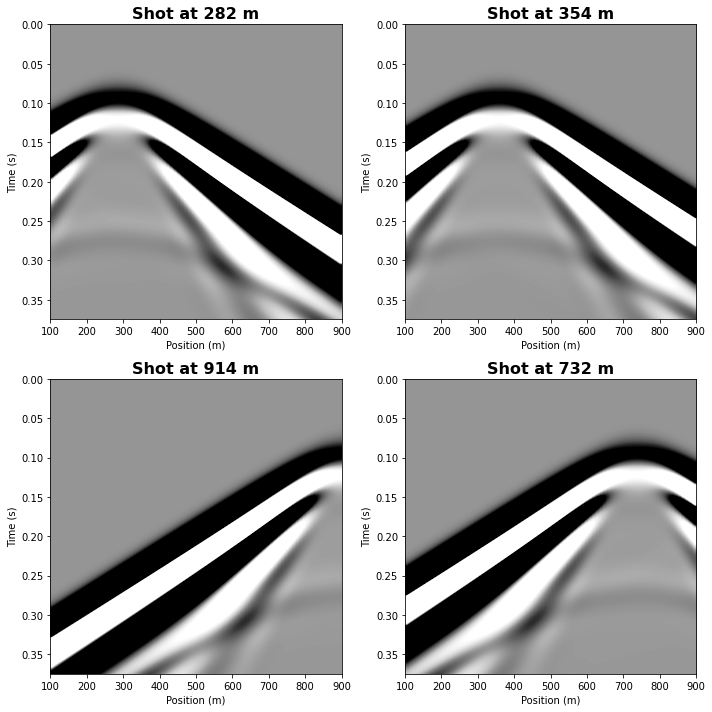

In [32]:
fig2 = plt.figure(figsize = (10,10))
ax2 = []
extent = [50*dh, 450*dh, (datashots[0].shape[0]-1)*dt, 0]
clip = 0.1

vmax = np.max(datashots) * clip
vmin = -vmax

for idx, shot in enumerate(jobids):
    
    ax2.append(fig2.add_subplot(2,2,idx+1))
    ax2[idx].imshow(datashots[idx], aspect='auto', vmax=vmax, vmin=vmin,
            extent=extent, interpolation='bilinear',
            cmap=plt.get_cmap('Greys'))
    ax2[idx].set_title('Shot at ' + str(sx_allshot[shot]) + ' m',
                     fontsize=16, fontweight='bold')
    ax2[idx].set_xlabel("Position (m)")
    ax2[idx].set_ylabel("Time (s)")

plt.tight_layout()

plt.show()